# Napovedovanje cen kripto valut, s pomočjo pogovorov na socialnih platformah

Podatkovno rudarjenje, projektna naloga, `18.5.2021`  
**`Nik Prinčič`**  
**`Jaka Škerjanc`**  
**`Erik Pahor`**


### Opis problema

Področje naše raziskave je trg kripto valut, bolj natančno kako pogovori na platformah kot sta Discord in Reddit, kjer si mnenja izmenjujeo predvsem kripto navdušenci, vplivajo na gibanje cen. Osredotočili se bomo predvsem na kriptovalute z nizko tržno kapitalizacijo (market cap).

Izbrane naloge, ki jih želimo raziskat:

* Ali lahko iz objav napovemo spremembo cene?
* Poiskati povezavo med ceno in popularnostjo na Reddit/Discord
* Ali kateri kovanci posebej izstopajo?
* Kako se je spreminajalo zanimanje za kripto valute?


### Pridobivanje podatkov

Podatke o objavah uporabnikov smo dobili na dveh platformah

* Discord: Tri skupnosti kripto navdušencev skupno preko 130.000 članov. Za obdobje od 1.2.2021 do 31.3.2021 smo pridobili skupno 1.700.000 sporočil. Ker Discord ne omogoča dostopa do sporočil preko kašnega vmesnika (npr. API), smo morali podatke pridobiti z programom [DiscordChatExporter](https://github.com/Tyrrrz/DiscordChatExporter), ki nam vrne .csv obliko. Da zmanjšamo velikost izbrišemo vse nepotrebne metapodatke. Na koncu nam ostane vsebina sporočila ter datum in čas.
* Reddit: Tukaj smo poiskali 4 "subreddite", kjer imajo vsak dan oziroma teden objavo v kateri uporabniki debatirajo o trenutno aktualnih zadevah. Pridobili smo komentarje iz 71 takih objav. Za to smo uporabili [PRAW: The Python Reddit API Wrapper](https://github.com/praw-dev/praw).


In [1]:
# python spaghetti code here


### Izvedene analize

Podatke o objavah uporabnikov smo dobili na dveh platformah


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import datetime
from collections import defaultdict

import os

BASE_PATH = os.path.abspath(os.path.curdir)
PRICE_DATA_DIR = os.path.join(BASE_PATH, "data/price_data/")
MENTIONS_COUNT_DIR = os.path.join(BASE_PATH, "data/date_count")

COLOR_MAIN = "#363A45"
COLOR_MA_5 = "#FF9800"
COLOR_MA_8 = "#E040FB"
COLOR_MA_13 = "#9C27B0"
COLOR_VOLUME = "#B2B5BE"

MIN_DATE = "2021-02-01 00:00:00"
MAX_DATE = "2021-04-05 03:00:00"

TITLE_SIZE = 20
AXES_LABELS_SIZE = 15

DATE_RANGE = pd.date_range(
    start=MIN_DATE,
    end=MAX_DATE,
    freq="2D",
)

plt.style.use("seaborn")

In [2]:
def date_parser(timestamp):
    return datetime.datetime.fromtimestamp(int(timestamp))

Text(0, 0.5, 'Coin')

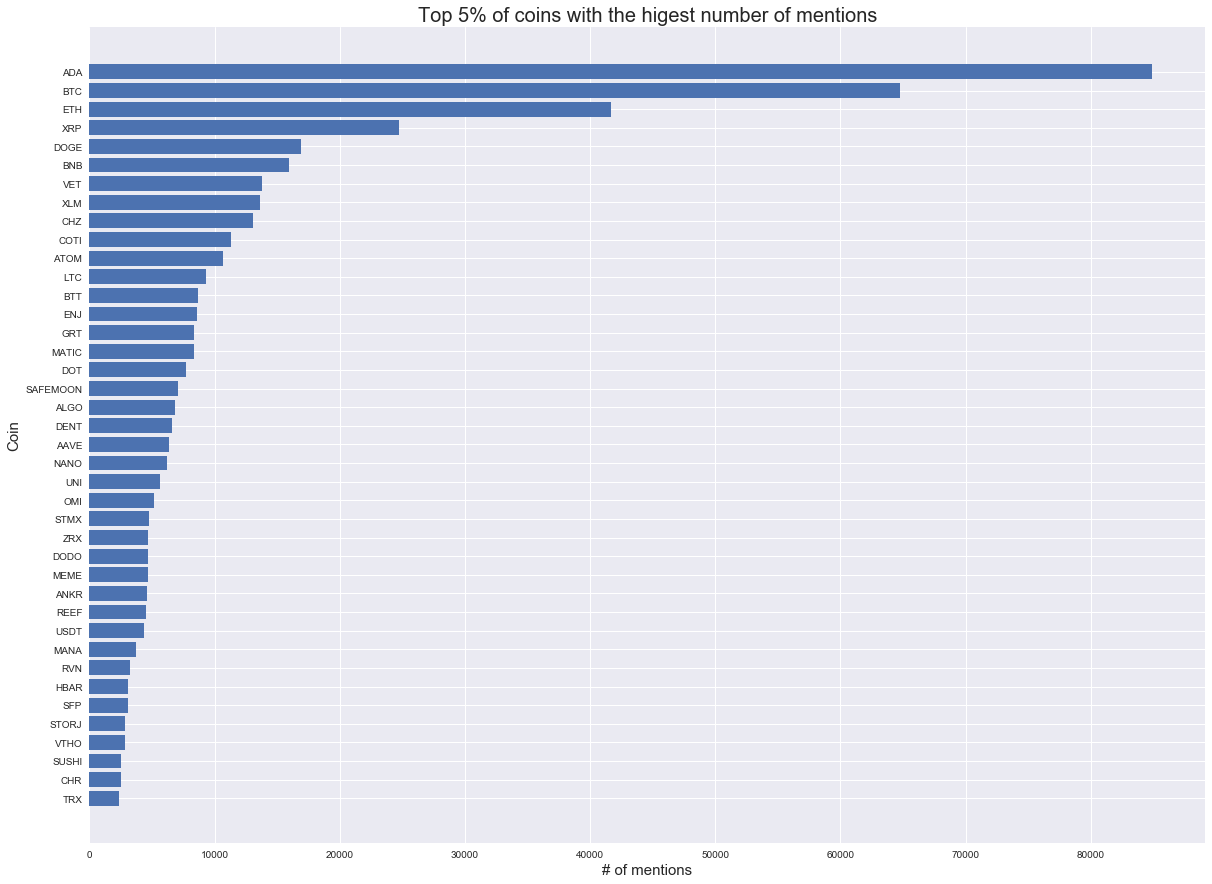

In [23]:
data = pd.read_csv(os.path.join(BASE_PATH, "data", "tracked_coins_details.csv"))
limit = data["count"].quantile(0.95)
data = data[data["count"] >= limit]
data = data.sort_values(by="count")

TRACKED_COINS = data["symbol"].array[::-1]

fig, ax = plt.subplots(figsize=(20, 15))

ax.barh(data["symbol"], data["count"])
ax.set_title("Top 5% of coins with the higest number of mentions", fontsize=TITLE_SIZE)
ax.set_xlabel("# of mentions", fontsize=AXES_LABELS_SIZE)
ax.set_ylabel("Coin", fontsize=AXES_LABELS_SIZE)

In [4]:
biggest_volume_diff = pd.DataFrame(
    columns=["coin", "min", "min_date", "max", "max_date", "diff", "diff_rel"]
)

for e in os.listdir(PRICE_DATA_DIR):
    if e not in TRACKED_COINS:
        continue

    df = pd.read_csv(os.path.join(PRICE_DATA_DIR, e, f"{e}_volume.csv"))
    min_ = df["volume"].min()
    max_ = df["volume"].max()
    min_date = df[df["volume"] == min_]["date"].array[0]
    max_date = df[df["volume"] == max_]["date"].array[0]
    diff = max_ - min_
    if min_ == 0:
        diff_rel = np.inf
    elif max_date > min_:
        diff_rel = (max_ / min_) - 1
    else:
        diff_rel = -((max_ / min_) - 1)
    biggest_volume_diff = biggest_volume_diff.append(
        {
            "coin": e,
            "min": min_,
            "min_date": min_date,
            "max": max_,
            "max_date": max_date,
            "diff": diff,
            "diff_rel": diff_rel * 100,
        },
        ignore_index=True,
    )
biggest_volume_diff = biggest_volume_diff.sort_values(by="diff_rel", ascending=False)

biggest_price_diff = pd.DataFrame(
    columns=["coin", "min", "min_date", "max", "max_date", "diff", "diff_rel"]
)

for e in os.listdir(PRICE_DATA_DIR):
    if e not in TRACKED_COINS:
        continue

    df = pd.read_csv(os.path.join(PRICE_DATA_DIR, e, f"{e}_price.csv"))
    min_ = df["price"].min()
    max_ = df["price"].max()
    min_date = df[df["price"] == min_]["date"].array[0]
    max_date = df[df["price"] == max_]["date"].array[0]
    diff = max_ - min_
    if min_ == 0:
        diff_rel = np.inf
    elif max_date > min_:
        diff_rel = (max_ / min_) - 1
    else:
        diff_rel = -((max_ / min_) - 1)
    biggest_price_diff = biggest_price_diff.append(
        {
            "coin": e,
            "min": min_,
            "min_date": min_date,
            "max": max_,
            "max_date": max_date,
            "diff": diff,
            "diff_rel": diff_rel * 100,
        },
        ignore_index=True,
    )
biggest_price_diff = biggest_price_diff.sort_values(by="diff_rel", ascending=False)

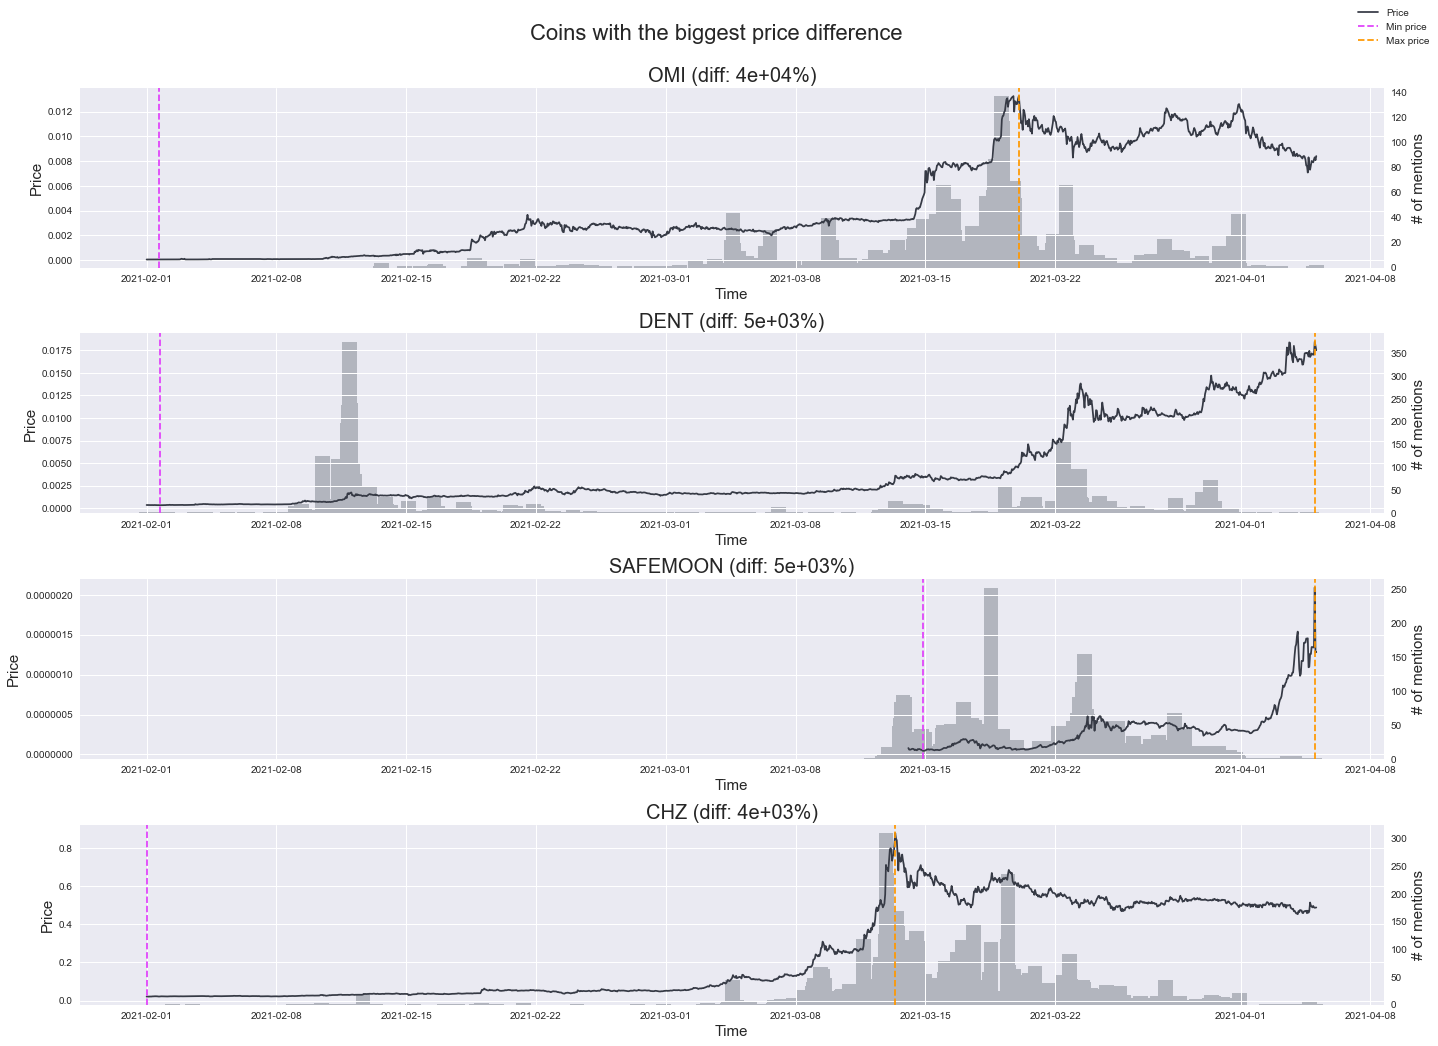

In [19]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15))

for i, e in enumerate(biggest_price_diff.iloc[0:4].iterrows()):
    coin = e[1]["coin"]
    mentions_data = pd.read_csv(
        os.path.join(MENTIONS_COUNT_DIR, f"{coin}.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    price_data = pd.read_csv(
        os.path.join(PRICE_DATA_DIR, coin, f"{coin}_price.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    ax_bar = ax[i].twinx()
    ax_bar.bar(
        mentions_data.index,
        mentions_data["count"],
        color=COLOR_VOLUME,
        label="Mentions",
    )
    ax[i].plot(price_data["price"], color=COLOR_MAIN, label="Price")

    ax[i].axvline(
        date_parser(e[1]["min_date"]),
        color=COLOR_MA_8,
        linestyle="--",
        label="Min price",
    )
    ax[i].axvline(
        date_parser(e[1]["max_date"]),
        color=COLOR_MA_5,
        linestyle="--",
        label="Max price",
    )

    ax[i].set_zorder(ax_bar.get_zorder() + 1)
    ax[i].patch.set_visible(False)
    ax[i].set_title(f"{coin} (diff: {e[1]['diff_rel']:.0}%)", fontsize=TITLE_SIZE)
    ax[i].set_xlabel("Time", fontsize=AXES_LABELS_SIZE)
    ax[i].set_ylabel("Price", fontsize=AXES_LABELS_SIZE)

    ax_bar.patch.set_visible(True)
    ax_bar.grid(b=None)
    ax_bar.set_ylabel("# of mentions", fontsize=AXES_LABELS_SIZE)


fig.legend(*ax[0].get_legend_handles_labels())
fig.suptitle("Coins with the biggest price difference", fontsize=22)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

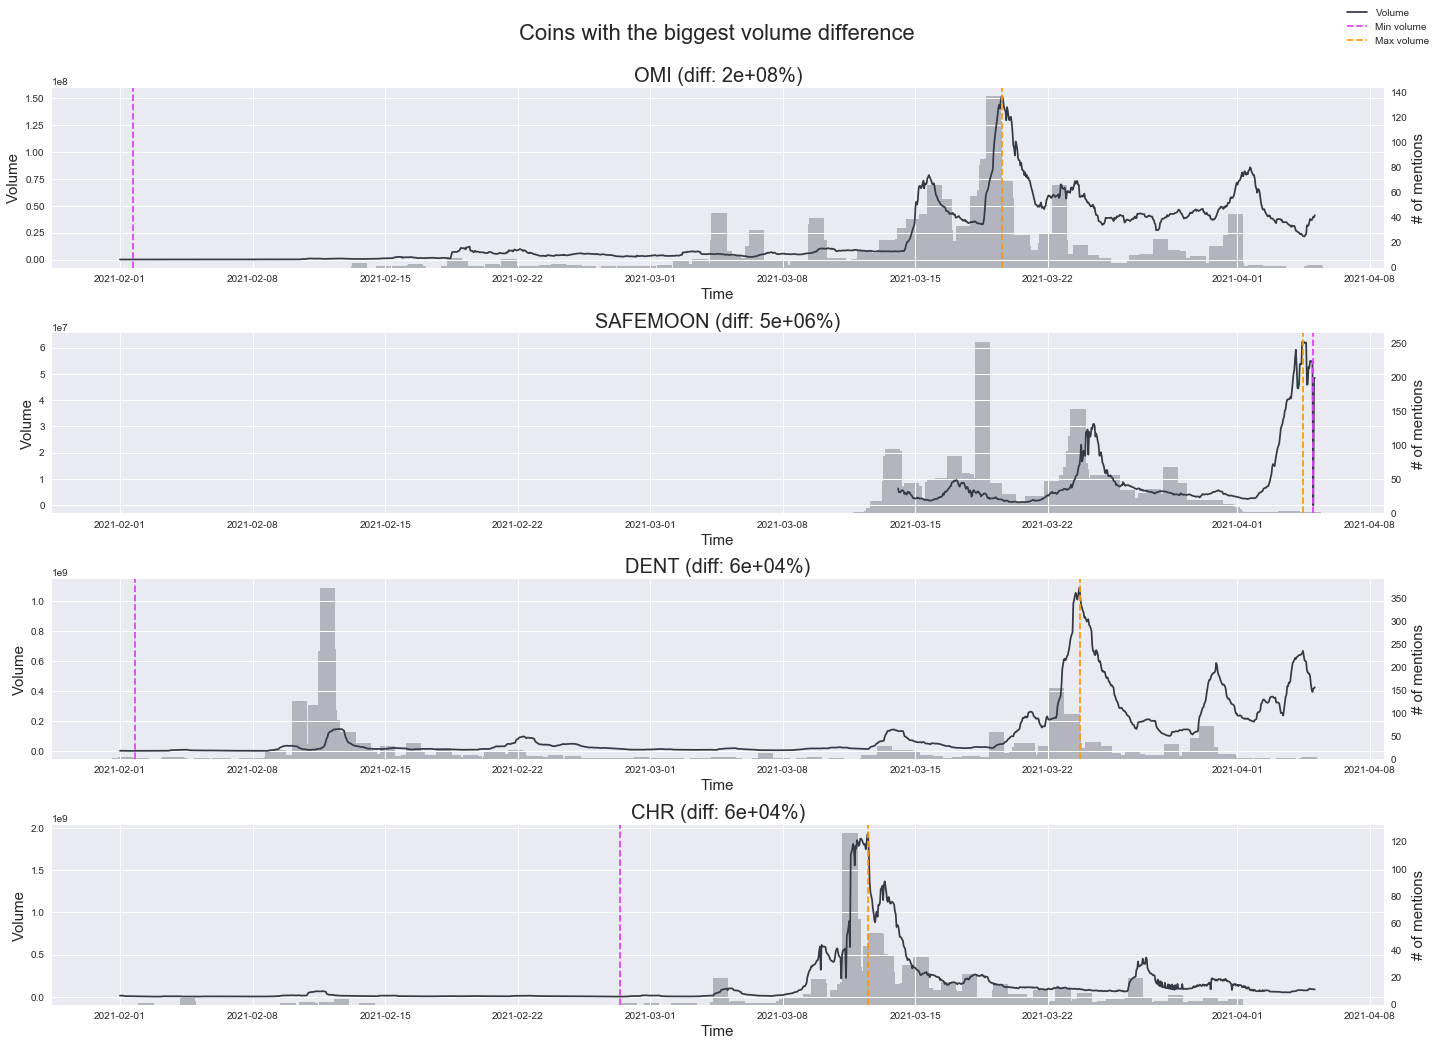

In [21]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15))

for i, e in enumerate(
    biggest_volume_diff[biggest_volume_diff["max"] != 0].iloc[0:4].iterrows()
):
    coin = e[1]["coin"]
    mentions_data = pd.read_csv(
        os.path.join(MENTIONS_COUNT_DIR, f"{coin}.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    volume_data = pd.read_csv(
        os.path.join(PRICE_DATA_DIR, coin, f"{coin}_volume.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    ax_bar = ax[i].twinx()
    ax_bar.bar(
        mentions_data.index,
        mentions_data["count"],
        color=COLOR_VOLUME,
        label="Mentions",
    )
    ax[i].plot(volume_data["volume"], color=COLOR_MAIN, label="Volume")

    ax[i].axvline(
        date_parser(e[1]["min_date"]),
        color=COLOR_MA_8,
        linestyle="--",
        label="Min volume",
    )
    ax[i].axvline(
        date_parser(e[1]["max_date"]),
        color=COLOR_MA_5,
        linestyle="--",
        label="Max volume",
    )

    ax[i].set_zorder(ax_bar.get_zorder() + 1)
    ax[i].patch.set_visible(False)
    ax[i].set_title(f"{coin} (diff: {e[1]['diff_rel']:.0}%)", fontsize=TITLE_SIZE)
    ax[i].set_xlabel("Time", fontsize=AXES_LABELS_SIZE)
    ax[i].set_ylabel("Volume", fontsize=AXES_LABELS_SIZE)

    ax_bar.patch.set_visible(True)
    ax_bar.grid(b=None)
    ax_bar.set_ylabel("# of mentions", fontsize=AXES_LABELS_SIZE)


fig.legend(*ax[0].get_legend_handles_labels())
fig.suptitle("Coins with the biggest volume difference", fontsize=22)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

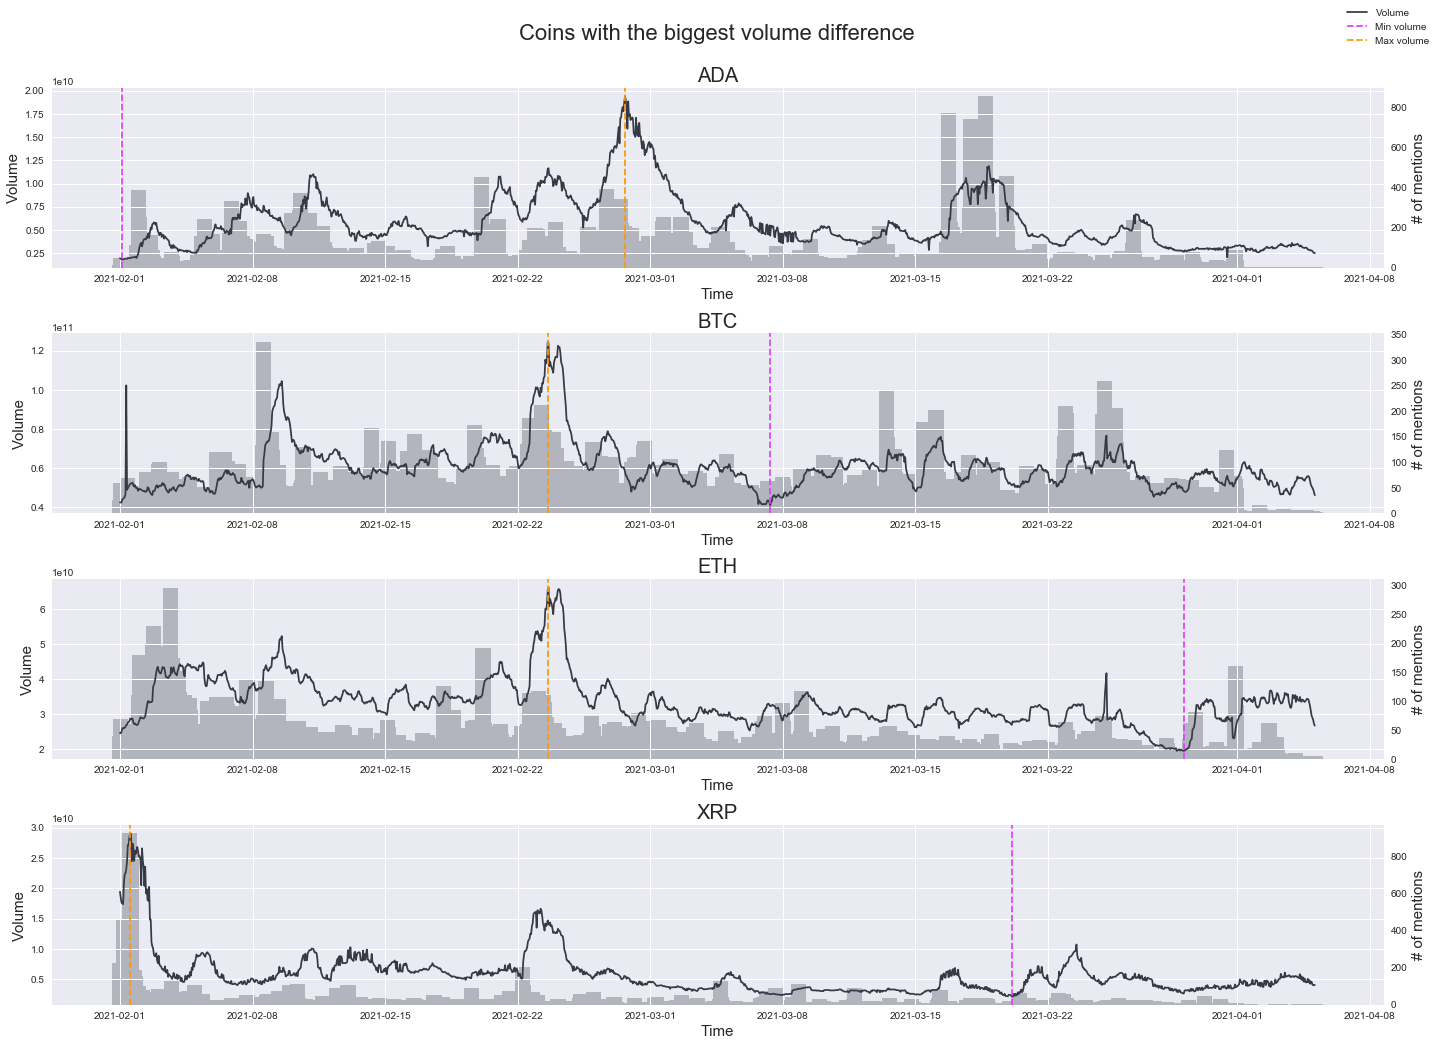

In [34]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15))


for i, e in enumerate(TRACKED_COINS[0:4]):
    coin = e
    mentions_data = pd.read_csv(
        os.path.join(MENTIONS_COUNT_DIR, f"{coin}.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    volume_data = pd.read_csv(
        os.path.join(PRICE_DATA_DIR, coin, f"{coin}_volume.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    ax_bar = ax[i].twinx()
    ax_bar.bar(
        mentions_data.index,
        mentions_data["count"],
        color=COLOR_VOLUME,
        label="Mentions",
    )
    ax[i].plot(volume_data["volume"], color=COLOR_MAIN, label="Volume")

    min_date = biggest_volume_diff[biggest_volume_diff["coin"] == e]["min_date"]
    max_date = biggest_volume_diff[biggest_volume_diff["coin"] == e]["max_date"]

    ax[i].axvline(
        date_parser(min_date),
        color=COLOR_MA_8,
        linestyle="--",
        label="Min volume",
    )
    ax[i].axvline(
        date_parser(max_date),
        color=COLOR_MA_5,
        linestyle="--",
        label="Max volume",
    )

    ax[i].set_zorder(ax_bar.get_zorder() + 1)
    ax[i].patch.set_visible(False)
    ax[i].set_title(f"{coin}", fontsize=TITLE_SIZE)
    ax[i].set_xlabel("Time", fontsize=AXES_LABELS_SIZE)
    ax[i].set_ylabel("Volume", fontsize=AXES_LABELS_SIZE)

    ax_bar.patch.set_visible(True)
    ax_bar.grid(b=None)
    ax_bar.set_ylabel("# of mentions", fontsize=AXES_LABELS_SIZE)


fig.legend(*ax[0].get_legend_handles_labels())
fig.suptitle("Coins with the biggest volume difference", fontsize=22)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [24]:
fig, ax = plt.subplots(4, 1, figsize=(20, 15))


for i, e in enumerate(TRACKED_COINS[0:4]):
    coin = e
    mentions_data = pd.read_csv(
        os.path.join(MENTIONS_COUNT_DIR, f"{coin}.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    price_data = pd.read_csv(
        os.path.join(PRICE_DATA_DIR, coin, f"{coin}_price.csv"),
        parse_dates=True,
        date_parser=date_parser,
        index_col="date",
    )
    ax_bar = ax[i].twinx()
    ax_bar.bar(
        mentions_data.index,
        mentions_data["count"],
        color=COLOR_VOLUME,
        label="Mentions",
    )
    ax[i].plot(price_data["price"], color=COLOR_MAIN, label="Price")

    min_date = biggest_volume_diff[biggest_volume_diff["coin"] == e]["min_date"]
    max_date = biggest_volume_diff[biggest_volume_diff["coin"] == e]["max_date"]

    ax[i].axvline(
        date_parser(min_date),
        color=COLOR_MA_8,
        linestyle="--",
        label="Min price",
    )
    ax[i].axvline(
        date_parser(max_date),
        color=COLOR_MA_5,
        linestyle="--",
        label="Max price",
    )

    ax[i].set_zorder(ax_bar.get_zorder() + 1)
    ax[i].patch.set_visible(False)
    ax[i].set_title(f"{coin}", fontsize=TITLE_SIZE)
    ax[i].set_xlabel("Time", fontsize=AXES_LABELS_SIZE)
    ax[i].set_ylabel("Volume", fontsize=AXES_LABELS_SIZE)

    ax_bar.patch.set_visible(True)
    ax_bar.grid(b=None)
    ax_bar.set_ylabel("# of mentions", fontsize=AXES_LABELS_SIZE)


fig.legend(*ax[0].get_legend_handles_labels())
fig.suptitle("Coins with the biggest volume difference", fontsize=22)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

<PandasArray>
[     'ADA',      'BTC',      'ETH',      'XRP',     'DOGE',      'BNB',
      'VET',      'XLM',      'CHZ',     'COTI',     'ATOM',      'LTC',
      'BTT',      'ENJ',      'GRT',    'MATIC',      'DOT', 'SAFEMOON',
     'ALGO',     'DENT',     'AAVE',     'NANO',      'UNI',      'OMI',
     'STMX',      'ZRX',     'DODO',     'MEME',     'ANKR',     'REEF',
     'USDT',     'MANA',      'RVN',     'HBAR',      'SFP',    'STORJ',
     'VTHO',    'SUSHI',      'CHR',      'TRX']
Length: 40, dtype: object

### Glavne ugotovitve

Trenutno smo še osredotočeni na pridobivanje čim več kvalitetnih podatkov, ki bodo v nadaljevanju osnova za uspešno iskanje odgovorov v podatkih.
